# Sales Forecasting and Inventory Insights with Machine Learning: Synthetic Data Case Study

*A practical demonstration of demand forecasting using time series models and strategic inventory risk analysis with synthetic retail data.*


**Author:** Jose Araújo  
**Date:** 25/09/2025


**GitHub:** [https://github.com/josefaquino](https://github.com/josefaquino)


## Technical Development Plan for ML-Based Demand Forecasting and Inventory Optimization Project

### Month 1: Foundations of Forecasting and Monitoring

1. **Demand Forecasting Model**
   - Develop time series models that account for seasonality, stockouts, and competitor behavior.
   - Recommended techniques:
     - Hybrid models: Prophet combined with tree-based methods like LightGBM to incorporate external variables.
     - Deep learning models (LSTM, Transformers with attention) based on data volume and infrastructure.
     - Advanced feature engineering including holidays, promotions, market events, and competitor data.

2. **Safety Stock Calculator**
   - Integrate forecast uncertainty and lead-time variability to calculate adaptive safety stock levels.
   - Use probabilistic models and Monte Carlo simulations to assess risks and define inventory buffers.

3. **Daily Stockout Risk Alert System**
   - Build an automated system that monitors forecast and inventory status to generate early stockout alerts.
   - Implement APIs or dashboards presenting key risk indicators to the purchasing team.

### Month 2: Competitiveness and Market Monitoring

1. **Buy Box Share Prediction Model**
   - Create predictive models to estimate Buy Box winning probability on Amazon based on price, availability, and competitor signals.
   - Apply classification and scoring techniques like XGBoost or neural networks with categorical embeddings.

2. **Competitor Inventory Monitoring**
   - Develop data pipelines for frequent collection of competitor inventory via scraping or APIs.
   - Incorporate competitor inventory data into forecasting and alert systems.

3. **Strategic Purchase Opportunity Scanner**
   - Analyze market gaps and competitor stock levels to recommend strategic purchase opportunities with higher sales potential.

### Month 3: Advanced Optimization and Automation

1. **Price Elasticity Models by Product Category**
   - Analyze how price changes affect demand elasticity per category, using regression and causal inference models.

2. **Automated Purchasing Decision Engine**
   - Implement a decision system using business rules and reinforcement learning to optimize replenishment balancing cost, risk, and demand.

3. **Full Integration**
   - Seamlessly integrate forecasting, optimization, and alert tools with existing company systems and provide thorough user documentation.

---

This structured plan aims to deliver impactful, scalable, and production-ready ML solutions tailored to the complexities of a large-scale Amazon retail inventory environment.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DEBUG:cmdstanpy:input tempfile: /tmp/tmp890y_d3f/f0mdnixl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp890y_d3f/7m9ympg9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48079', 'data', 'file=/tmp/tmp890y_d3f/f0mdnixl.json', 'init=/tmp/tmp890y_d3f/7m9ympg9.json', 'output', 'file=/tmp/tmp890y_d3f/prophet_modelj229kea_/prophet_model-20250926015450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


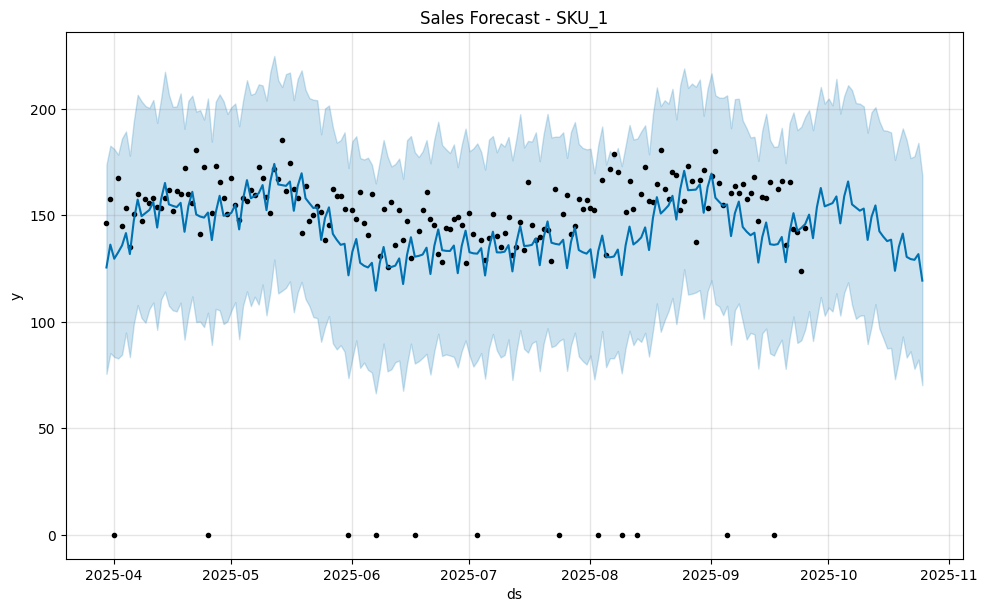

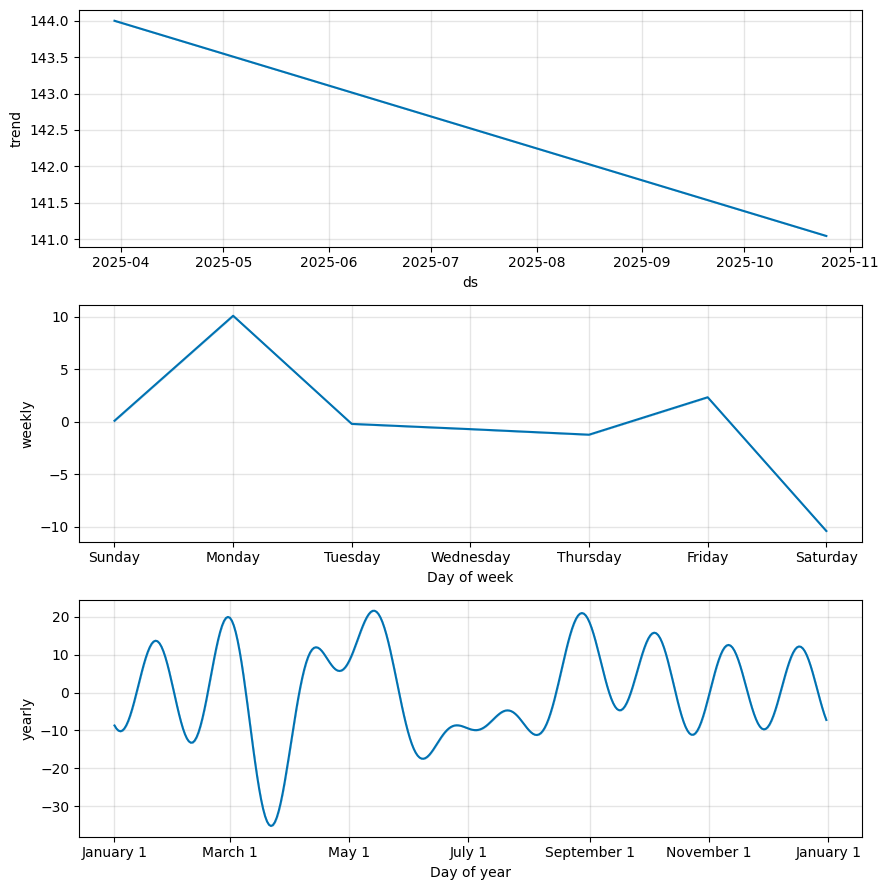

Top SKUs with risk of stockout (most zero sales days):
sku
SKU_3     18
SKU_11    15
SKU_7     14
SKU_6     13
SKU_1     12
dtype: int64

Top SKUs with highest demand variability:
sku
SKU_11    50.074841
SKU_10    47.956108
SKU_14    40.539771
SKU_1     40.360021
SKU_4     40.136372
Name: sales, dtype: float64


In [2]:
# -*- coding: utf-8 -*-
# Colab code for Forecasting and Insights with Synthetic Data

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
from google.colab import files

# --- Generate synthetic data ---

num_skus = 20
periods = 180  # 6 months of data
start_date = datetime.today() - timedelta(days=periods)
dates = pd.date_range(start=start_date, periods=periods)

np.random.seed(42)
rows = []
for sku in range(1, num_skus + 1):
    base_demand = np.random.randint(50, 200)  # average daily demand
    seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, periods))  # simple seasonality
    noise = np.random.normal(0, 10, periods)  # noise
    demand = base_demand + seasonality + noise
    demand = np.clip(demand, 0, None)  # demand is not negative

    stockouts = np.random.choice([0, 1], size=periods, p=[0.05, 0.95])  # 5% stockouts
    demand = demand * stockouts

    for date, sales in zip(dates, demand):
        rows.append({'date': date, 'sku': f'SKU_{sku}', 'sales': sales})

synthetic_data = pd.DataFrame(rows)

# Save CSV file for download
synthetic_data.to_csv('synthetic_sales_data.csv', index=False)
files.download('synthetic_sales_data.csv')


# --- Forecast model for 1 SKU ---

# Use the first SKU for forecasting example
sku_id = synthetic_data['sku'].unique()[0]
sku_data = synthetic_data[synthetic_data['sku'] == sku_id][['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

# Create and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(sku_data)

# Make forecast for next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title(f'Sales Forecast - {sku_id}')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

# --- Strategic insights ---

# 1) SKUs with most stockouts (zero sales days)
#ruptures = synthetic_data.groupby('sku').apply(lambda x: (x['sales'] == 0).sum()).sort_values(ascending=False)
ruptures = synthetic_data.groupby('sku').apply(
    lambda x: (x['sales'] == 0).sum(),
    include_groups=False
).sort_values(ascending=False)


# 2) SKUs with highest demand variability (candidates for higher safety stock)
variability = synthetic_data.groupby('sku')['sales'].std().sort_values(ascending=False)

print("Top SKUs with risk of stockout (most zero sales days):")
print(ruptures.head(5))

print("\nTop SKUs with highest demand variability:")
print(variability.head(5))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp890y_d3f/cwzca00z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp890y_d3f/vtg8qvz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19348', 'data', 'file=/tmp/tmp890y_d3f/cwzca00z.json', 'init=/tmp/tmp890y_d3f/vtg8qvz8.json', 'output', 'file=/tmp/tmp890y_d3f/prophet_model_2m7g32j/prophet_model-20250926020338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 26.68
Root Mean Squared Error (RMSE): 47.56


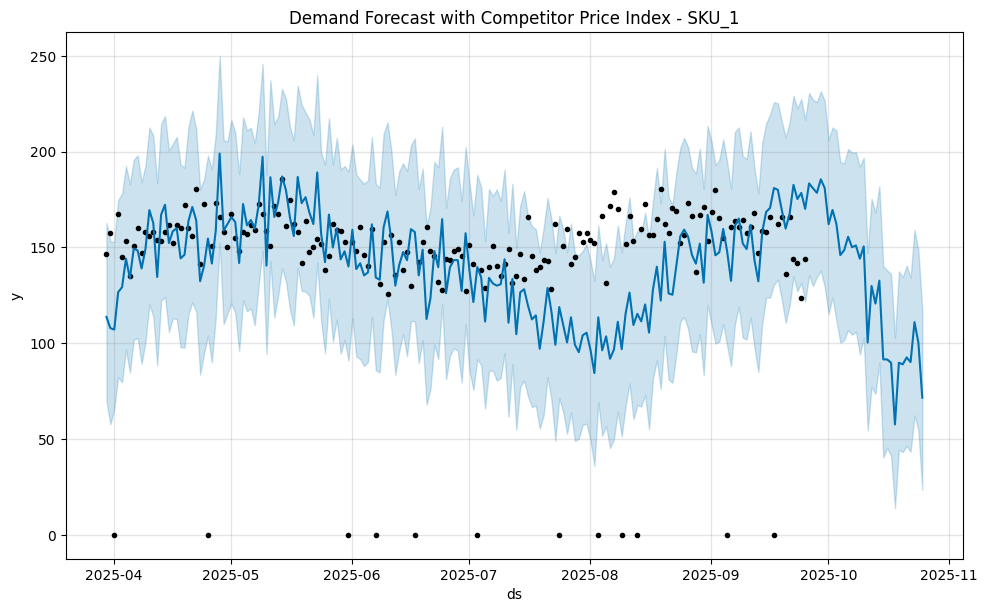

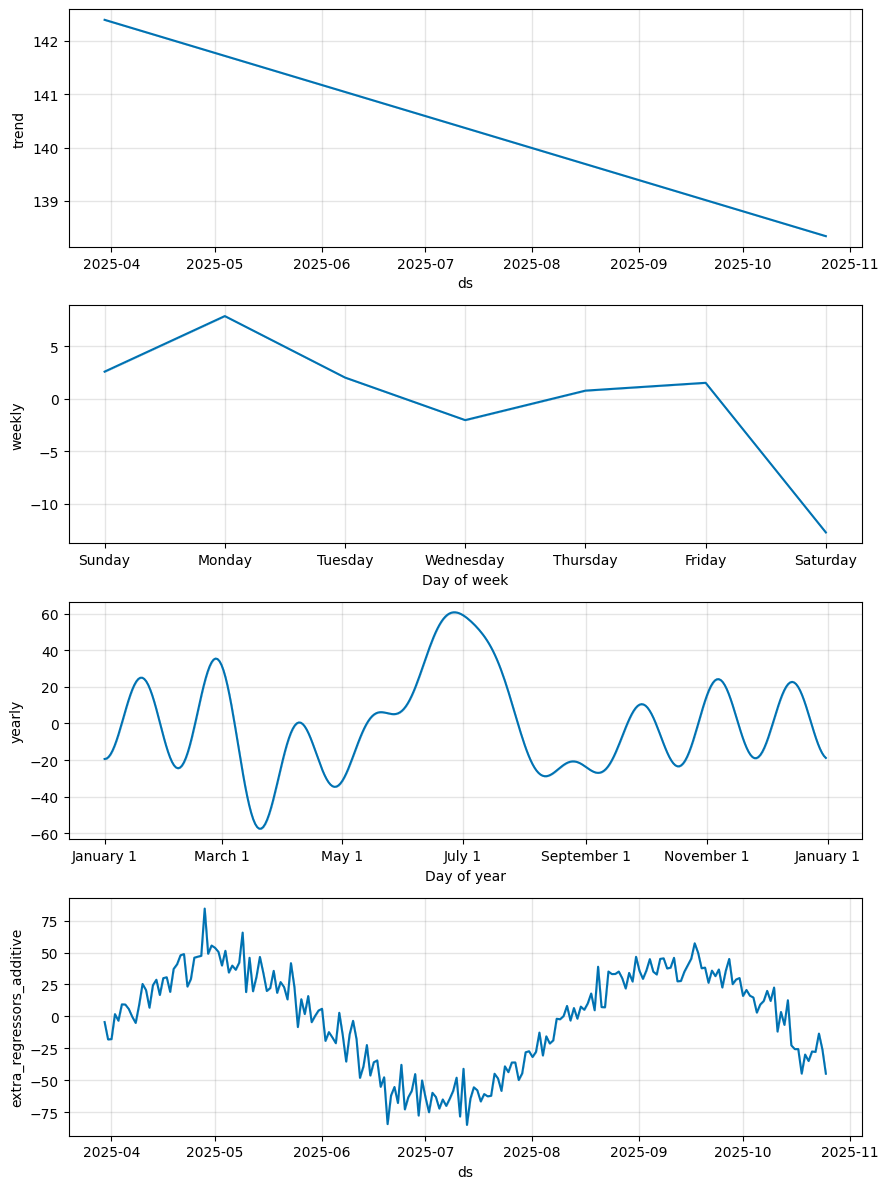

In [4]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load synthetic data previously generated
df = synthetic_data.copy()

# Prepare data for Prophet: choose one SKU as example
sku_id = df['sku'].unique()[0]
sku_data = df[df['sku'] == sku_id][['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})

# Add external regressors simulating competitor price index (synthetic)
np.random.seed(42)
# Generate competitor price index for historical period
comp_price_index_hist = 1 + 0.1 * np.sin(np.linspace(0, 3 * np.pi, len(sku_data))) + np.random.normal(0, 0.02, len(sku_data))
sku_data['comp_price_index'] = comp_price_index_hist

# Initialize Prophet with extra regressors
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.add_regressor('comp_price_index')

# Fit model
model.fit(sku_data)

# Create future dataframe including 30 days for prediction
future = model.make_future_dataframe(periods=30)

# Generate competitor price index for full period (historical + future)
full_comp_price_index = 1 + 0.1 * np.sin(np.linspace(0, 3 * np.pi + np.pi/6, len(future))) + np.random.normal(0, 0.02, len(future))
full_comp_price_df = pd.DataFrame({'ds': future['ds'], 'comp_price_index': full_comp_price_index})

# Merge competitor price index into future dataframe, ensure no NaNs
future = future.drop(columns=['comp_price_index'], errors='ignore')
future = pd.merge(future, full_comp_price_df, on='ds', how='left')
future['comp_price_index'] = future['comp_price_index'].ffill()

# Predict
forecast = model.predict(future)

# Evaluate on known period (hold-out last 30 days)
eval_true = sku_data['y'].tail(30).values
eval_pred = forecast['yhat'].head(len(sku_data)).tail(30).values
mae = mean_absolute_error(eval_true, eval_pred)
rmse = np.sqrt(mean_squared_error(eval_true, eval_pred))
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot forecast and components
fig1 = model.plot(forecast)
plt.title(f'Demand Forecast with Competitor Price Index - {sku_id}')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


In [5]:
import numpy as np

# Parameters for Safety Stock Calculation
service_level = 0.95  # Desired service level (95%)
Z = 1.65  # z-score for 95% service level (from standard normal distribution)

# Assume lead time parameters (in days)
lead_time_mean = 7      # average lead time of 7 days
lead_time_std = 2       # std deviation of lead time is 2 days

# Calculate demand statistics from historical data
# Using the same SKU data as before
demand_mean = sku_data['y'].mean()         # average daily demand
demand_std = sku_data['y'].std()           # standard deviation daily demand

# Safety stock formula considering demand and lead time variability
safety_stock = Z * np.sqrt((demand_std ** 2) * lead_time_mean + (demand_mean ** 2) * (lead_time_std ** 2))

print(f"Average daily demand: {demand_mean:.2f}")
print(f"Demand standard deviation: {demand_std:.2f}")
print(f"Lead time mean (days): {lead_time_mean}")
print(f"Lead time std deviation (days): {lead_time_std}")
print(f"Calculated safety stock (units): {safety_stock:.2f}")


Average daily demand: 143.65
Demand standard deviation: 40.36
Lead time mean (days): 7
Lead time std deviation (days): 2
Calculated safety stock (units): 505.72


In [6]:
# Assume we have the current stock level for the SKU under analysis (or for all SKUs)
current_stock = 450  # Example: current stock in units

# Compare with the calculated safety stock
if current_stock < safety_stock:
    print(f"ALERT: Stock for {sku_id} is below safety stock level! Current stock: {current_stock:.0f}, Safety stock: {safety_stock:.0f}")
else:
    print(f"Stock level for {sku_id} is healthy. Current stock: {current_stock:.0f}, Safety stock: {safety_stock:.0f}")


ALERT: Stock for SKU_1 is below safety stock level! Current stock: 450, Safety stock: 506


### This simple script can be adapted to run daily with real inventory data to generate alerts via email, dashboards, or reporting tools.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:08:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC Score: 0.425

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       146
           1       0.21      0.07      0.11        54

    accuracy                           0.68       200
   macro avg       0.47      0.49      0.46       200
weighted avg       0.59      0.68      0.61       200



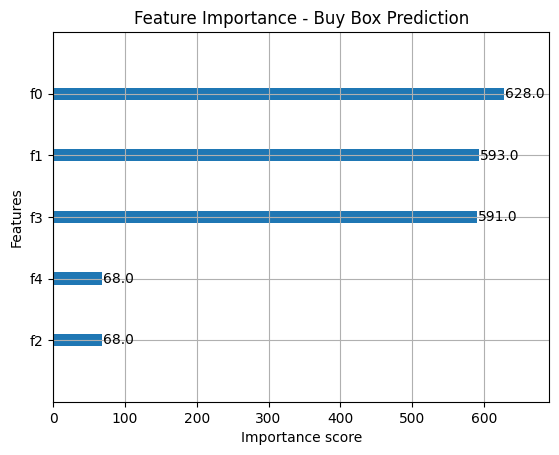

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Generate synthetic dataset for Buy Box prediction
np.random.seed(42)
num_samples = 1000

data = pd.DataFrame({
    'price_diff': np.random.normal(0, 10, num_samples),          # price difference to competitor (negative means cheaper)
    'inventory_level': np.random.randint(0, 500, num_samples),   # current inventory
    'fba': np.random.choice([0, 1], num_samples),                # Fulfilled by Amazon (1) or not (0)
    'seller_rating': np.random.uniform(3.5, 5.0, num_samples),   # seller rating (3.5 to 5)
    'promotion': np.random.choice([0, 1], num_samples),          # promotion running (1) or not (0)
    'buy_box_win': np.random.choice([0, 1], num_samples, p=[0.7, 0.3])  # target variable, 1 means won buy box
})

# Features and target
X = data.drop('buy_box_win', axis=1)
y = data['buy_box_win']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

# Evaluation
auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {auc:.3f}\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance plot (optional)
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.title('Feature Importance - Buy Box Prediction')
plt.show()


In [8]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Parameters
num_days = 2 * 365 + 30  # approximately 2 years and 1 month
dates = pd.date_range(start='2023-01-01', periods=num_days)

# Simulation output dataframe
data = pd.DataFrame({'date': dates})

# Annual seasonality (sine) + weekly trends + noise
data['base_sales'] = 50 + 20 * np.sin(2 * np.pi * data.index / 365) + 5 * np.sin(2 * np.pi * data.index / 7)
data['base_sales'] += np.random.normal(0, 5, num_days)
data['base_sales'] = np.clip(data['base_sales'], 0, None)

# Competitor price fluctuates around 100, with noise and trend
data['comp_price'] = 100 + 5 * np.sin(2 * np.pi * data.index / 180) + np.random.normal(0, 2, num_days)

# Our pricing strategy (price relative to competitor)
data['price_diff'] = np.random.normal(-1, 2, num_days)  # price slightly lower than competitor

# Daily stock levels simulating declines and replenishments
stock = 300
stock_levels = []
for i in range(num_days):
    demand = max(0, int(data.loc[i, 'base_sales'] + np.random.normal(0, 3)))
    stock = max(0, stock - demand)
    if i % 14 == 0:  # replenishment every 2 weeks
        stock += 200 + np.random.randint(-20, 20)
    stock_levels.append(stock)
data['stock_level'] = stock_levels

# Random promotions on 15% of days
data['promotion'] = (np.random.rand(num_days) < 0.15).astype(int)

# Seller rating with small variation
data['seller_rating'] = np.clip(np.random.normal(4.7, 0.1, num_days), 3.5, 5.0)

# Basic probability of winning the Buy Box based on price and stock
data['buy_box_prob'] = (
    0.3 * (data['price_diff'] < 0).astype(float) +
    0.4 * (data['stock_level'] > 50).astype(float) +
    0.1 * data['promotion'] +
    0.2 * ((data['seller_rating'] - 3.5) / 1.5)
)
data['buy_box_prob'] = data['buy_box_prob'].clip(0, 1)

# Simulate whether Buy Box was won on that day
data['buy_box_win'] = (np.random.rand(num_days) < data['buy_box_prob']).astype(int)

# Select features for modeling
data_model = data[[
    'date', 'price_diff', 'stock_level', 'promotion', 'seller_rating', 'buy_box_win'
]]

print(data_model.head())

# This dataset can now be used to train the Buy Box Share prediction model


        date  price_diff  stock_level  promotion  seller_rating  buy_box_win
0 2023-01-01    1.442067          469          0       4.679627            0
1 2023-01-02    0.164195          418          0       4.880652            0
2 2023-01-03   -1.452968          357          0       4.664929            1
3 2023-01-04   -2.918878          295          0       4.804999            1
4 2023-01-05   -1.744414          249          0       4.733889            1


ROC AUC Score: 0.665

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        77
           1       0.62      0.71      0.66        75

    accuracy                           0.64       152
   macro avg       0.64      0.64      0.64       152
weighted avg       0.64      0.64      0.64       152



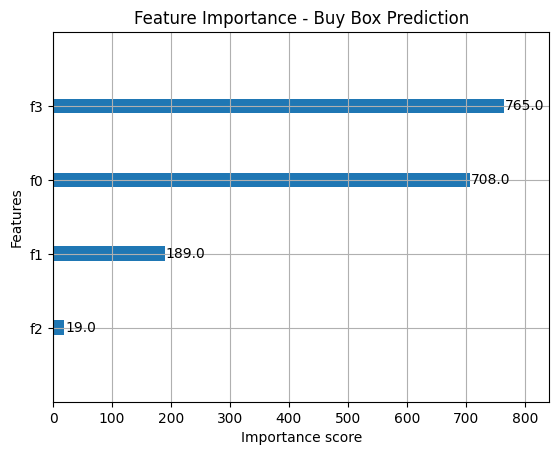

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb

# Assume data_model is your synthetic dataset from before
data = data_model.copy()

# Features and target
X = data.drop(['date', 'buy_box_win'], axis=1)
y = data['buy_box_win']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Classifier training
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities and classes
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

# Evaluate
auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {auc:.3f}\n')

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance plot
xgb.plot_importance(model)
plt.title('Feature Importance - Buy Box Prediction')
plt.show()


In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# Balancear dados usando SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, random_state=42, stratify=y_resampled)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo XGBoost
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train_scaled, y_train)

# Avaliar
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]
y_pred = model.predict(X_test_scaled)

auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score after SMOTE: {auc:.3f}\n')
print("Classification Report after SMOTE:")
print(classification_report(y_test, y_pred))


ROC AUC Score after SMOTE: 0.674

Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        77
           1       0.59      0.64      0.61        77

    accuracy                           0.60       154
   macro avg       0.60      0.60      0.60       154
weighted avg       0.60      0.60      0.60       154



In [11]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Parâmetros para tunagem
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Usar dados balanceados com SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo base
xgb_clf = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

# Configurar busca randomizada - reduz tempo comparado ao grid search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Executar busca
random_search.fit(X_train_scaled, y_train)

# Melhor modelo e parâmetros
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Avaliar no teste
y_pred_proba = best_model.predict_proba(X_test_scaled)[:,1]
y_pred = best_model.predict(X_test_scaled)

auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score after tuning: {auc:.3f}')
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
ROC AUC Score after tuning: 0.707
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        77
           1       0.65      0.70      0.68        77

    accuracy                           0.66       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.66      0.66      0.66       154



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:14:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [12]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Simular dados de estoque de concorrentes para 100 SKUs ao longo de 60 dias
num_skus = 100
num_days = 60
dates = pd.date_range(start='2025-07-01', periods=num_days)

# Gerar DataFrame com estoque diário por SKU concorrente
data_list = []
for sku in range(1, num_skus + 1):
    stock_level = 500 + np.random.randint(-50, 50)  # estoque inicial variado
    for day in dates:
        # Simula consumo e reabastecimento
        demand = max(0, int(np.random.normal(10, 3)))
        stock_level = max(0, stock_level - demand)
        if np.random.rand() < 0.1:  # reposição ocasional
            stock_level += np.random.randint(50, 150)
        data_list.append({'date': day, 'sku': f'SKU_{sku}', 'competitor_stock': stock_level})

competitor_stock_df = pd.DataFrame(data_list)

print(competitor_stock_df.head(10))


        date    sku  competitor_stock
0 2025-07-01  SKU_1               495
1 2025-07-02  SKU_1               622
2 2025-07-03  SKU_1               615
3 2025-07-04  SKU_1               744
4 2025-07-05  SKU_1               736
5 2025-07-06  SKU_1               725
6 2025-07-07  SKU_1               715
7 2025-07-08  SKU_1               711
8 2025-07-09  SKU_1               705
9 2025-07-10  SKU_1               695


In [16]:
import pandas as pd
import numpy as np
import plotly.express as px

np.random.seed(42)

# ----- Step 1: Generate synthetic competitor stock data -----
num_skus = 100
num_days = 60
dates = pd.date_range(start='2025-07-01', periods=num_days)

data_list = []
for sku in range(1, num_skus + 1):
    stock_level = 500 + np.random.randint(-50, 50)  # initial stock varied
    for day in dates:
        demand = max(0, int(np.random.normal(10, 3)))  # daily demand with noise
        stock_level = max(0, stock_level - demand)
        if np.random.rand() < 0.1:  # occasional restocking
            stock_level += np.random.randint(50, 150)
        data_list.append({'date': day, 'sku': f'SKU_{sku}', 'competitor_stock': stock_level})

competitor_stock_df = pd.DataFrame(data_list)

# ----- Step 2: Calculate rolling average & std dev, define low stock alert -----
competitor_stock_df['stock_7d_avg'] = competitor_stock_df.groupby('sku')['competitor_stock'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
competitor_stock_df['stock_7d_std'] = competitor_stock_df.groupby('sku')['competitor_stock'].transform(lambda x: x.rolling(window=7, min_periods=1).std().fillna(0))
competitor_stock_df['low_stock_alert'] = competitor_stock_df['competitor_stock'] < (competitor_stock_df['stock_7d_avg'] - competitor_stock_df['stock_7d_std'])

# ----- Step 3: Generate synthetic own stock data -----
own_stock_data = []
for sku in range(1, num_skus + 1):
    stock_level = 300 + np.random.randint(-30, 30)
    for day in dates:
        stock_level = max(0, stock_level + np.random.randint(-10, 10))  # small fluctuations
        own_stock_data.append({'date': day, 'sku': f'SKU_{sku}', 'own_stock': stock_level})

df_own_stock = pd.DataFrame(own_stock_data)

# ----- Step 4: Merge dataframes for opportunity scanning -----
stock_comp = pd.merge(competitor_stock_df, df_own_stock, on=['date', 'sku'])

# Filter opportunities: competitor low stock AND own stock above threshold (e.g., 100)
opportunities = stock_comp[(stock_comp['low_stock_alert']) & (stock_comp['own_stock'] > 100)]

print("Sample opportunities:")
print(opportunities[['date', 'sku', 'competitor_stock', 'own_stock', 'low_stock_alert']].head(10))

# ----- Step 5: Visualization -----
# Aggregate average stock over time
daily_comp_stock = competitor_stock_df.groupby('date')['competitor_stock'].mean().reset_index()
daily_own_stock = df_own_stock.groupby('date')['own_stock'].mean().reset_index()
stock_comparison = pd.merge(daily_comp_stock, daily_own_stock, on='date', how='inner')

# Plot average stock levels over time
fig = px.line(stock_comparison, x='date', y=['competitor_stock', 'own_stock'],
              labels={'value': 'Average Stock Level', 'date': 'Date', 'variable': 'Inventory'},
              title='Average Competitor vs Own Stock Over Time')
fig.show()

# Plot competitor stock and low stock alerts for a specific SKU
sku_select = 'SKU_1'
sku_data = competitor_stock_df[competitor_stock_df['sku'] == sku_select].copy()

fig2 = px.line(sku_data, x='date', y='competitor_stock', title=f'Competitor Stock Over Time - {sku_select}')
fig2.add_scatter(x=sku_data[sku_data['low_stock_alert']]['date'],
                 y=sku_data[sku_data['low_stock_alert']]['competitor_stock'],
                 mode='markers', name='Low Stock Alert', marker=dict(color='red', size=10))
fig2.show()



Sample opportunities:
         date    sku  competitor_stock  own_stock  low_stock_alert
9  2025-07-10  SKU_1               695        280             True
10 2025-07-11  SKU_1               681        286             True
11 2025-07-12  SKU_1               672        290             True
12 2025-07-13  SKU_1               664        284             True
13 2025-07-14  SKU_1               654        286             True
14 2025-07-15  SKU_1               646        279             True
15 2025-07-16  SKU_1               637        285             True
22 2025-07-23  SKU_1               701        293             True
23 2025-07-24  SKU_1               692        298             True
24 2025-07-25  SKU_1               680        303             True


In [17]:
import plotly.express as px
import pandas as pd

# Assume competitor_stock_df and df_own_stock were created previously

# Aggregate stocks by date for overview
daily_competitor_stock = competitor_stock_df.groupby('date')['competitor_stock'].mean().reset_index()
daily_own_stock = df_own_stock.groupby('date')['own_stock'].mean().reset_index()

# Merge for comparative plotting
stock_comparison = pd.merge(daily_competitor_stock, daily_own_stock, on='date', how='inner')

# Plot average competitor and own stock levels over time
fig = px.line(stock_comparison, x='date', y=['competitor_stock', 'own_stock'],
              labels={'value': 'Average Stock Level', 'date': 'Date', 'variable': 'Inventory'},
              title='Average Competitor vs Own Stock Over Time')
fig.show()

# Visualize low stock alerts for a specific SKU example
sku_select = 'SKU_1'
sku_data = competitor_stock_df[competitor_stock_df['sku'] == sku_select].copy()

fig2 = px.line(sku_data, x='date', y='competitor_stock', title=f'Competitor Stock Over Time - {sku_select}')
fig2.add_scatter(x=sku_data[sku_data['low_stock_alert']]['date'],
                 y=sku_data[sku_data['low_stock_alert']]['competitor_stock'],
                 mode='markers', name='Low Stock Alert', marker=dict(color='red', size=10))
fig2.show()


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(42)

# --- Step 1: Prepare dataset for predicting future competitor low stock ---

# Use competitor_stock_df from before, sorted by sku and date
df = competitor_stock_df.sort_values(['sku', 'date']).copy()

# Create target: will competitor stock be low in next 3 days? (binary classification)
df['future_low_stock'] = df.groupby('sku')['low_stock_alert'].shift(-3).fillna(False).astype(bool).astype(int)

# Features: current stock, rolling averages/std, stock 1 day ago
df['stock_1d_ago'] = df.groupby('sku')['competitor_stock'].shift(1).fillna(method='bfill')

# Select relevant columns and drop rows with NA
feature_cols = ['competitor_stock', 'stock_7d_avg', 'stock_7d_std', 'stock_1d_ago']
df_model = df.dropna(subset=feature_cols + ['future_low_stock'])

X = df_model[feature_cols]
y = df_model['future_low_stock']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 2: Train XGBoost model to predict future low stock ---
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
model.fit(X_train_scaled, y_train)

# --- Step 3: Evaluate model ---
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC Score: {auc:.3f}')
print(classification_report(y_test, y_pred))

# --- Step 4: Generate automatic alert messages for predicted low stock ---
test_results = X_test.copy()
test_results['pred_proba'] = y_pred_proba
test_results['pred_label'] = y_pred
test_results['sku'] = df_model.loc[X_test.index, 'sku']
test_results['date'] = df_model.loc[X_test.index, 'date']

alerts = test_results[test_results['pred_label'] == 1]

for _, row in alerts.iterrows():
    msg = (
        f"ALERT: Competitor stock for {row['sku']} expected to be low around {row['date'].date()}. "
        f"Predicted probability: {row['pred_proba']:.2f}. "
        "Recommend reviewing inventory and pricing strategy."
    )
    print(msg)


/tmp/ipython-input-2864356555.py:16: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-2864356555.py:19: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[02:24:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




ROC AUC Score: 0.775
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       594
           1       0.70      0.80      0.75       606

    accuracy                           0.73      1200
   macro avg       0.73      0.73      0.72      1200
weighted avg       0.73      0.73      0.73      1200

ALERT: Competitor stock for SKU_29 expected to be low around 2025-08-11. Predicted probability: 0.64. Recommend reviewing inventory and pricing strategy.
ALERT: Competitor stock for SKU_31 expected to be low around 2025-07-22. Predicted probability: 0.67. Recommend reviewing inventory and pricing strategy.
ALERT: Competitor stock for SKU_96 expected to be low around 2025-08-10. Predicted probability: 0.66. Recommend reviewing inventory and pricing strategy.
ALERT: Competitor stock for SKU_47 expected to be low around 2025-08-17. Predicted probability: 0.88. Recommend reviewing inventory and pricing strategy.
ALERT: Competitor stock for SKU_67 e

# Advanced Alternatives for AI-Powered Alert Systems

## 1. ChatOps with Intelligent Assistants
- Integrate alerts and notifications into real-time communication channels such as Slack, Microsoft Teams, or Discord.
- Use AI-powered bots (chatbots) that receive, interpret, and respond to dynamic queries about alerts and inventory status.

## 2. Low-code/No-code Platforms with Built-in AI
- Utilize platforms that support automated workflows integrating predictive models and AI-driven text generation.
- Examples include Microsoft Power Automate, Zapier connected with GPT-4 via API, or finance-specific automation tools.

## 3. Contextual Notifications and Automated Narratives
- Apply language models to generate natural language reports that explain alerts clearly, enhancing understanding and trust.
- Integrate these narrative alerts into ERP systems or financial dashboards for seamless operational use.

## 4. Custom Virtual Assistant API
- Build a bespoke virtual assistant for the purchasing team with an API accessible through mobile or web apps.
- The AI assistant can answer questions about stock levels, market trends, and recommend actions based on historical data analysis.

---


### Considering the project scope, existing data infrastructure, and quick impact, the most effective implementation is:

ChatOps with Intelligent Assistants on Slack
Slack is widely used in professional environments, enabling real-time communication and collaboration.

Implementing a Slack bot integrated with the predictive model allows instant, context-rich alert delivery and interactive query handling.

This approach avoids traditional email delays and improves operational agility.

Slack's API is well-documented, and many open-source libraries facilitate bot development and AI integration.